In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline

We will now retrieve and process the CSV file containing actual weather data for the city of Birmingham, Alabama. In order to later aggregate the electricity generated daily, we divide the Date and Time data into additional columns.

In [46]:
df = pd.read_csv('Actual_33.55_-86.85_2006_DPV_39MW_5_Min.csv')
df.head()
df['LocalTime'] = pd.to_datetime(df['LocalTime'], format="%m/%d/%y %H:%M")
df['Date'] = df['LocalTime'].dt.date
df['Time'] = df['LocalTime'].dt.time
print(df.head())

            LocalTime  Power(MW)        Date      Time
0 2006-01-01 00:00:00        0.0  2006-01-01  00:00:00
1 2006-01-01 00:05:00        0.0  2006-01-01  00:05:00
2 2006-01-01 00:10:00        0.0  2006-01-01  00:10:00
3 2006-01-01 00:15:00        0.0  2006-01-01  00:15:00
4 2006-01-01 00:20:00        0.0  2006-01-01  00:20:00


To designate that total value as the dependent variable later on, we will want to take the total MW generated across all of the entire days in the year. After that, we'll correlate it with a number of independent variables, including local meteorological characteristics from another dataset.

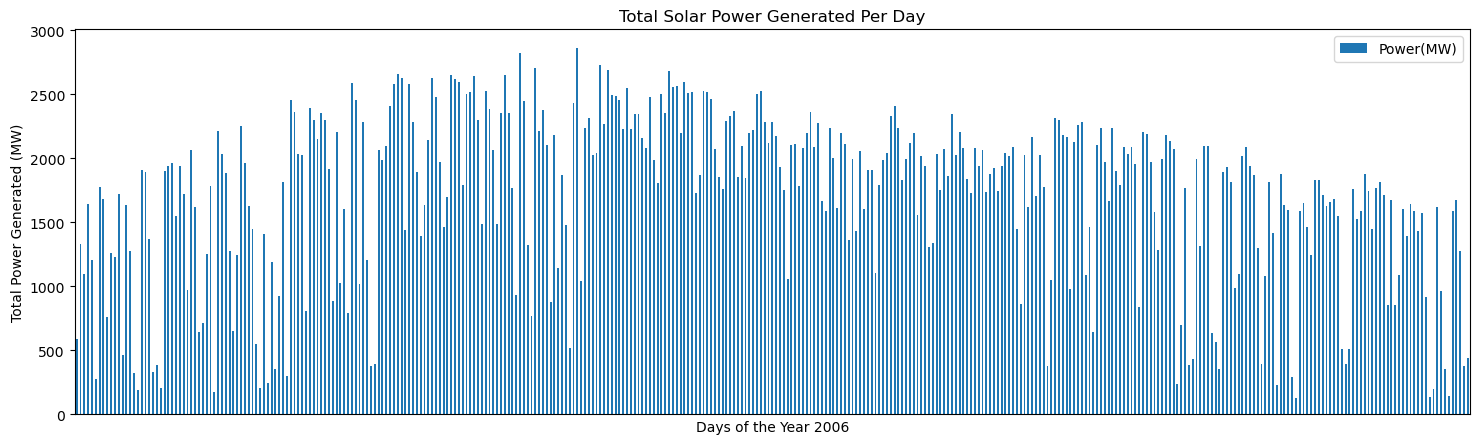

In [47]:
days_df = df.groupby('Date').sum('Power(MW)').reset_index()
days_df.plot(kind='bar',x='Date',y='Power(MW)',xlabel='Days of the Year 2006',ylabel='Total Power Generated (MW)')

plt.gca().set_title('Total Solar Power Generated Per Day')
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gcf().set_size_inches(18, 5)

In the data above, there appears to be a bell-shaped distribution among the higher values, reaching its peak during the summer months, with numerous lower values scattered throughout. To develop a predictive model for the total daily power generation, we'll import a distinct CSV file containing essential weather variables for the specified time and location.

In [48]:
features = pd.read_csv('Birmingham_Weather_2006.csv')
new_df = days_df.merge(features,on='Date',how='right')
new_df['Power(MW)'] = days_df['Power(MW)']
new_df = new_df.drop('Unnamed: 0',inplace=False,axis=1)
new_df.head()

,Date,Power(MW),Temp(F),Humidity,Hrs Daylight
0,2006-01-01,585.5,58.1,74.1,9.98
1,2006-01-02,1332.0,68.1,70.3,9.98
2,2006-01-03,1096.6,49.3,72.9,10.00
3,2006-01-04,1646.3,53.8,66.9,10.02
4,2006-01-05,1205.6,45.1,68.1,10.02


Create feature variables for regression

In [58]:
X = new_df.drop('Power(MW)',axis=1)
X.drop('Date',inplace=True,axis=1)
y = new_df['Power(MW)'].to_numpy().reshape(-1,1)

Before training our model, we will attempt to visualize the data in order to better understand the parameters that are being utilized
for our model before committing to regression.

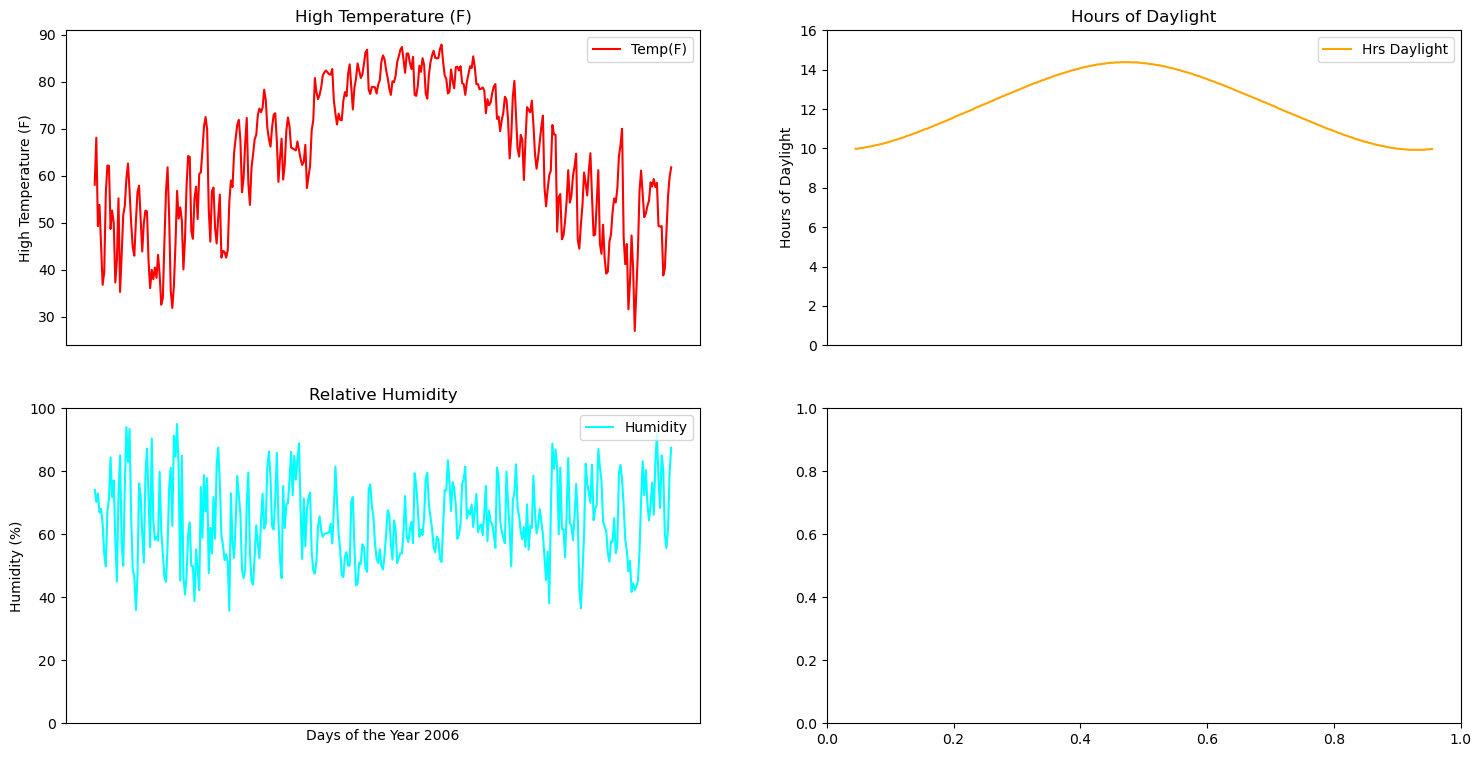

In [67]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(18, 9))

features.plot(kind='line', x='Date', y='Temp(F)', ax=axs[0, 0], color='red')
axs[0, 0].set_xlabel('')
axs[0, 0].set_ylabel('High Temperature (F)')
axs[0, 0].set_title('High Temperature (F)')
axs[0, 0].xaxis.set_major_locator(plt.NullLocator())

features.plot(kind='line', x='Date', y='Hrs Daylight', ax=axs[0, 1], color='orange')
axs[0, 1].set_xlabel('')
axs[0, 1].set_ylabel('Hours of Daylight')
axs[0, 1].set_title('Hours of Daylight')
axs[0, 1].set_ylim(0, 16)
axs[0, 1].xaxis.set_major_locator(plt.NullLocator())

features.plot(kind='line', x='Date', y='Humidity', ax=axs[1, 0], color='cyan')
axs[1, 0].set_xlabel('Days of the Year 2006')
axs[1, 0].set_ylabel('Humidity (%)')
axs[1, 0].set_title('Relative Humidity')
axs[1, 0].set_ylim(0, 100)
axs[1, 0].legend(loc='upper right')
axs[1, 0].xaxis.set_major_locator(plt.NullLocator())

To understand model performance, dividing the dataset into training data and testing data is a brilliant strategy. Split the data into 90% training data and 10% testing.

Let's split the dataset by using the function train_test_split(). You need to pass 3 parameters: features, target, and test_set size. Additionally, you can use random_state to select records randomly.

Then, fit the linear regression model on the train set using fit() and perform prediction on the test set using predict(). 

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.1,random_state=40)

model = LinearRegression()
model.fit(X_train,y_train)
print(model.coef_)
coefs = pd.concat([pd.DataFrame(X.columns),pd.DataFrame(np.transpose(model.coef_))],axis=1, ignore_index=True)
coefs.rename(columns={0:'Features',1:'Coefficients'},inplace=True)
print(coefs)

[[ -2.99637511 -30.62063198 212.45003114]]
       Features  Coefficients
0       Temp(F)     -2.996375
1      Humidity    -30.620632
2  Hrs Daylight    212.450031


Unexpectedly, Temperature seems to be have a negative correlation with the amount solar power generated, while Hours of Daylight is positively. The negative correlation could be explained by the fact that a certain point or temperature, the efficiency of solar panels starts decreasing as the temperature increases . 
Let's make predictions about the solar power generated based on our weather data

In [75]:
y_pred = model.predict(X_test)

predict_df = pd.DataFrame(y_test)
predict_df.columns = ['Actual Value (MW)']

predict_df['Predicted Value (MW)'] = pd.DataFrame(y_pred).apply(lambda value:round(value,1))

predict_df['Difference'] = y_pred-y_test
predict_df['Difference'] = predict_df['Difference'].apply(lambda value:round(value,1))

predict_df['% Error'] = round(100*(predict_df['Difference']/predict_df['Actual Value (MW)']), 2)
print(predict_df)
print('\nAverage Difference')
print(round(predict_df['Difference'].sum()/37,2))

    Actual Value (MW)  Predicted Value (MW)  Difference  % Error
0              1861.3                1751.1      -110.2    -5.92
1              2137.5                1869.1      -268.4   -12.56
2              1900.8                1891.5        -9.3    -0.49
3              1044.0                1854.4       810.4    77.62
4               642.0                1118.3       476.3    74.19
5              1260.7                1060.4      -200.3   -15.89
6              2099.8                1787.0      -312.8   -14.90
7              1023.3                1174.1       150.8    14.74
8              1298.5                1534.8       236.3    18.20
9              2452.9                2035.2      -417.7   -17.03
10             2297.2                2077.5      -219.7    -9.56
11             2081.1                2186.5       105.4     5.06
12             2454.3                2161.6      -292.7   -11.93
13             1878.9                1401.0      -477.9   -25.44
14             1831.5    

The negative average difference signified that the linear regression model has a tendency to understimate the solar power generated. It can be observed that days with higher power generated are especially receptive to underestimation, while days on which lower power was generated are more likely to be subjected to overestimation. Overall, the error differences seem to average out

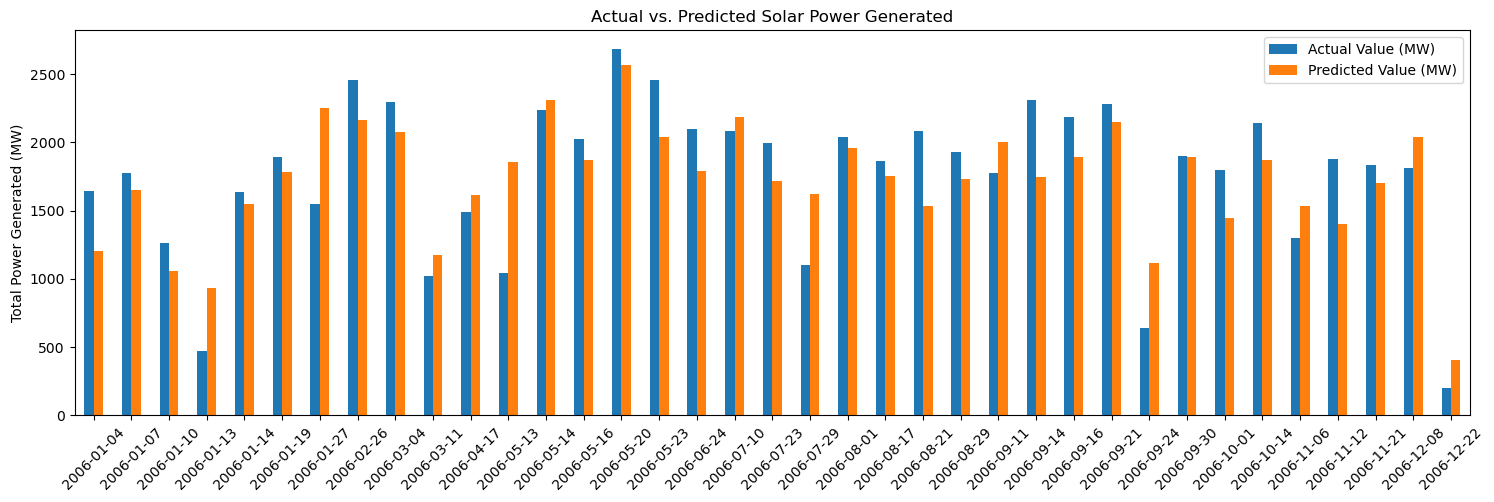

In [77]:
merge_test_df = predict_df.merge(new_df,
                  left_on='Actual Value (MW)', right_on='Power(MW)', how='left')
merge_test_df.sort_values(by=['Date'], inplace=True)
merge_test_df = merge_test_df.reset_index(drop=True)

merge_test_df.plot(x='Date', y=['Actual Value (MW)', 'Predicted Value (MW)'], xlabel='', ylabel='Total Power Generated (MW)', kind="bar", rot=45)
plt.gca().set_title('Actual vs. Predicted Solar Power Generated')
plt.gcf().set_size_inches(18, 5)